# **클래스실습**

In [1]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# 디바이스 준비
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## **1. 클래스의 기본 개념**

In [2]:
class Dog:
    def __init__(self, name, age):
        self.name = name
        self.age = age

    def bark(self):
        return f"{self.name}가 멍멍 짖습니다."
    def get_age(self):
        return self.age

In [3]:
dog1 = Dog(name="초코", age=3)
dog2 = Dog(name="바둑이", age=5)
print(dog1.bark())
print(dog2.get_age())

초코가 멍멍 짖습니다.
5


## **2. 모델을 클래스로 선언하기**

### (1) 기본 모델 설계

* 직접 선언 방식

In [4]:
n_feature = 10
model = nn.Sequential(nn.Linear(n_feature, 3),
                        nn.ReLU(),
                        nn.Linear(3, 1)
                        ).to(device)

* 클래스 선언 방식

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, n_feature):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_feature, 3)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(3, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = NeuralNet(n_feature).to(device)

### (2) 여러 가지 모델 클래스 설계 방법

* 직접 선언 방식

In [6]:
n_feature = 28 * 28
n_class = 10
model = nn.Sequential(nn.Flatten(),
                    nn.Linear(n_feature, 256),
                    nn.ReLU(),
                    nn.Dropout(p=.3),
                    nn.Linear(256, 64),
                    nn.ReLU(),
                    nn.Dropout(p=.3),
                    nn.Linear(64, n_class)
                    ).to(device)

* 클래스 선언 방식 1: 기본

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, n_feature, n_class):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, n_class)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = NeuralNet(n_feature=28*28, n_class=10).to(device)

* 클래스 선언 방식 2: 중첩

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, n_feature, n_class):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, n_class)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        # 입력 데이터의 순전파 흐름 정의
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = NeuralNet(n_feature=28*28, n_class=10).to(device)

* 클래스 선언 방식 3: 모듈화(Sequential로 묶기)

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, n_feature, n_class): # 모델에 사용할 층 정의
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(n_feature, 256), nn.ReLU(),
        nn.Dropout(p=.3))
        self.fc2 = nn.Sequential(nn.Linear(256, 64), nn.ReLU(), nn.Dropout(p=.3))
        self.fc3 = nn.Linear(64, n_class)
    def forward(self, x): # 입력 데이터의 순전파 과정 정의
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## **3. 클래스로 모델링하기 실습**

### (1) 환경준비

In [10]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# 디바이스 준비
device = 'cuda' if torch.cuda.is_available() else 'cpu'

* 딥러닝을 위한 데이터로더 만들기

In [11]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [12]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터 세트의 크기
    num_batches = len(dataloader) # 배치 크기
    tr_loss = 0

    model.train() # 학습 모드로 설정
    for x, y in dataloader: # 배치 단위로 로딩
        x, y = x.to(device), y.to(device) # 디바이스 지정

        # Feed Forward(오차 순전파)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation(오차 역전파)
        loss.backward() # 역전파를 통해 각 파라미터에 대한 오차의 기울기 계산
        optimizer.step() # 옵티마이저가 모델의 파라미터를 업데이트
        optimizer.zero_grad() # 옵티마이저의 기울기값 초기화.

    tr_loss /= num_batches # 모든 배치의 오차 평균
    return tr_loss.item()

* 검증을 위한 함수

In [13]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정

    with torch.no_grad(): # 평가 과정에서 기울기를 계산하지 않도록 설정
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item() # 예측값 pred와 목푯값 y 사이의 오차 계산

    return eval_loss, pred

* 학습곡선

In [14]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1)) # 에포크 수 계산
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.') # 학습 오차 그래프
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.') # 검증 오차 그래프
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터 전처리

* 데이터 세트 다운로드

In [15]:
# MNIST 데이터 다운로드
from torchvision import datasets
from torchvision.transforms import ToTensor
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

# 학습 데이터로 데이터 로더 구성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# 검증 및 테스트 데이터 준비
## 검증, 테스트 데이터 분할
x_val, x_test = test_dataset.data[:5000], test_dataset.data[5000:]
y_val, y_test = test_dataset.targets[:5000], test_dataset.targets[5000:]

## 스케일링
x_val = x_val / 255
x_test = x_test/ 255

## 차원 맞추기
x_val = x_val.view(5000, 1, 28, 28)
x_test = x_test.view(5000, 1, 28, 28)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.52MB/s]


### (3) 클래스로 모델링하기

* 클래스 선언

In [16]:
class NeuralNet(nn.Module):
    def __init__(self, n_feature, n_class):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, n_class)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

* 모델 선언 및 학습, 예측, 평가

Epoch 1, train loss : 0.420846, val loss : 0.241288
Epoch 2, train loss : 0.186707, val loss : 0.156818
Epoch 3, train loss : 0.139361, val loss : 0.133058
Epoch 4, train loss : 0.117568, val loss : 0.124322
Epoch 5, train loss : 0.098467, val loss : 0.122306
Epoch 6, train loss : 0.086917, val loss : 0.107833
Epoch 7, train loss : 0.077794, val loss : 0.103698
Epoch 8, train loss : 0.072378, val loss : 0.103890
Epoch 9, train loss : 0.068401, val loss : 0.102108
Epoch 10, train loss : 0.062167, val loss : 0.113489


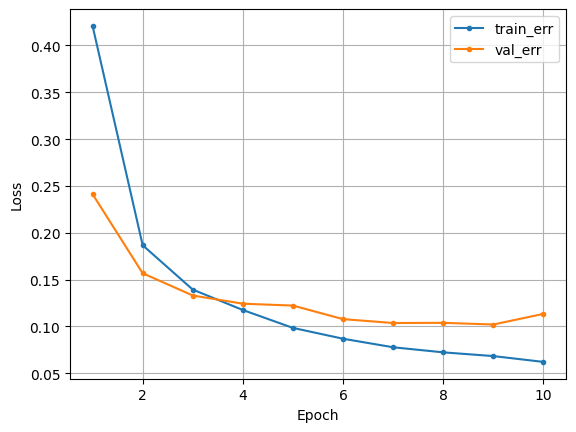

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       520
           1       1.00      0.99      0.99       564
           2       0.99      0.99      0.99       502
           3       1.00      0.99      0.99       510
           4       0.99      0.99      0.99       482
           5       0.98      0.99      0.99       436
           6       0.99      0.99      0.99       496
           7       0.99      0.98      0.99       516
           8       0.98      0.99      0.98       485
           9       0.98      0.99      0.98       489

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [17]:
# 모델 선언
model = NeuralNet(n_feature=28*28, n_class=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# 학습
epochs = 10
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val, y_val, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

# 학습 곡선
dl_learning_curve(tr_loss_list, val_loss_list)

# 예측 및 평가
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)
pred = np.argmax(pred.numpy(), axis = 1)
print(classification_report(y_test, pred))

## **4. 다중 입력 구조의 모델 클래스 만들기**

### (1) 데이터 전처리

In [18]:
# 1. 데이터 로딩
path = 'https://bit.ly/ds_boston_csv'
data = pd.read_csv(path)

# 2. 데이터 세트 분할: x, y
target = 'medv'
x = data.drop(target, axis = 1)
y = data[target]

# 3. x1, x2 나누기
x1_cols = ['rm', 'age', 'zn', 'tax', 'indus']
x2_cols = ['crim', 'lstat', 'nox', 'dis', 'ptratio', 'rad']
x1 = data.loc[:, x1_cols]
x2 = data.loc[:, x2_cols]

* 스케일링

In [19]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
x1 = scaler1.fit_transform(x1)
x2 = scaler2.fit_transform(x2)
y = y.values

* train, test 분할

In [20]:
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x1, x2, y, test_size=0.2)

* 데이터 로더 생성

In [28]:
def make_DataSet(x1_train, x1_test, x2_train, x2_test, y_train, y_test, batch_size = 32):
    # 데이터 텐서로 변환
    x1_train = torch.tensor(x1_train, dtype=torch.float32)
    x2_train = torch.tensor(x2_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x1_test = torch.tensor(x1_test, dtype=torch.float32)
    x2_test = torch.tensor(x2_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x1_train, x2_train, y_train)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    return train_loader, x1_test, x2_test, y_test

In [29]:
# 학습 데이터의 데이터 로더, 테스트 텐서 데이터 준비
train_loader, x1_test, x2_test, y_test = make_DataSet(x1_train, x1_test, x2_train, x2_test, y_train, y_test, batch_size = 32)

/tmp/ipython-input-1224838413.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1_test = torch.tensor(x1_test, dtype=torch.float32)
/tmp/ipython-input-1224838413.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2_test = torch.tensor(x2_test, dtype=torch.float32)
/tmp/ipython-input-1224838413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


### (2) 모델링

* 모델 클래스 생성

In [23]:
class MultiInputNet(nn.Module):
    def __init__(self, input1_dim, input2_dim):
        super(MultiInputNet, self).__init__()
        self.fc1_branch = nn.Sequential(nn.Linear(input1_dim, 16), nn.ReLU())
        self.fc2_branch = nn.Sequential(nn.Linear(input2_dim, 16), nn.ReLU())
        self.fc_combined = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 1))
    def forward(self, x1, x2):
        out1 = self.fc1_branch(x1)
        out2 = self.fc2_branch(x2)
        combined = torch.cat((out1, out2), dim=1)
        output = self.fc_combined(combined)
        return output

* train 함수

In [24]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터 세트의 크기
    num_batches = len(dataloader) # 배치 크기
    tr_loss = 0
    model.train()
    for batch, (x1, x2, y) in enumerate(dataloader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        pred = model(x1, x2)
        loss = loss_fn(pred, y)
        tr_loss += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches
    return tr_loss.item()

* evaluate 함수

In [25]:
def evaluate(x1, x2, y, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        pred = model(x1, x2)
        eval_loss = loss_fn(pred, y).item()
    return eval_loss, pred

* 학습부터 예측 평가까지

In [26]:
# 모델 선언
input1_dim, input2_dim = len(x1_cols), len(x2_cols)
model = MultiInputNet(input1_dim, input2_dim).to(device)

# 오차 함수, 옵티마이저 지정
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# 학습
epochs = 50
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x1_test, x2_test, y_test, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 538.191895, val loss : 341.986725
Epoch 2, train loss : 260.704041, val loss : 65.362953
Epoch 3, train loss : 85.751099, val loss : 49.485054
Epoch 4, train loss : 46.376987, val loss : 24.704401
Epoch 5, train loss : 36.212936, val loss : 21.779917
Epoch 6, train loss : 31.770752, val loss : 17.161674
Epoch 7, train loss : 28.743727, val loss : 15.365140
Epoch 8, train loss : 26.955107, val loss : 13.064767
Epoch 9, train loss : 26.037809, val loss : 11.828474
Epoch 10, train loss : 22.033939, val loss : 10.520694
Epoch 11, train loss : 19.824322, val loss : 9.874650
Epoch 12, train loss : 19.999620, val loss : 10.125159
Epoch 13, train loss : 18.027481, val loss : 8.814816
Epoch 14, train loss : 17.087767, val loss : 9.655736
Epoch 15, train loss : 16.519777, val loss : 9.089383
Epoch 16, train loss : 16.137911, val loss : 9.836223
Epoch 17, train loss : 15.593223, val loss : 9.136225
Epoch 18, train loss : 15.566076, val loss : 8.955681
Epoch 19, train loss : 

In [27]:
from sklearn.metrics import *
_, pred = evaluate(x1_test, x2_test, y_test, model, loss_fn, device)
mae = mean_absolute_error(y_test.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_test.numpy(), pred.numpy())
print(f'MAE : {mae}')
print(f'MAPE : {mape}')

MAE : 2.435300827026367
MAPE : 0.13108791410923004
